### Identifying whether a Mushroom is Poisonous

Currently at 98.25% with incomplete K-Fold using Random Forest

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
train_data = pd.read_csv('playground-series-s4e8/train.csv')
test_data = pd.read_csv('playground-series-s4e8/test.csv')

### Overview

In [17]:
print(f'Shape of train dataset: {train_data.shape}'), print(f'Shape of test dataset: {test_data.shape}'), print(f'Duplicated rows: {train_data.duplicated().sum()}\n'), print(f'Missing values: { ( (train_data.isnull().sum().sum())/(train_data.shape[0]*train_data.shape[1]) )*100:.2f}%\n'), train_data.info()

Shape of train dataset: (3116945, 22)
Shape of test dataset: (2077964, 21)
Duplicated rows: 0

Missing values: 23.14 %

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3116945 entries, 0 to 3116944
Data columns (total 22 columns):
 #   Column                Dtype  
---  ------                -----  
 0   id                    int64  
 1   class                 object 
 2   cap-diameter          float64
 3   cap-shape             object 
 4   cap-surface           object 
 5   cap-color             object 
 6   does-bruise-or-bleed  object 
 7   gill-attachment       object 
 8   gill-spacing          object 
 9   gill-color            object 
 10  stem-height           float64
 11  stem-width            float64
 12  stem-root             object 
 13  stem-surface          object 
 14  stem-color            object 
 15  veil-type             object 
 16  veil-color            object 
 17  has-ring              object 
 18  ring-type             object 
 19  spore-print-color     objec

(None, None, None, None, None)

In [36]:
print(train_data.nunique(),'\n')

id                      3116945
class                         2
cap-diameter               3913
cap-shape                    74
cap-surface                  83
cap-color                    78
does-bruise-or-bleed         26
gill-attachment              78
gill-spacing                 48
gill-color                   63
stem-height                2749
stem-width                 5836
stem-root                    38
stem-surface                 60
stem-color                   59
veil-type                    22
veil-color                   24
has-ring                     23
ring-type                    40
spore-print-color            32
habitat                      52
season                        4
dtype: int64 



In [57]:
cat_columns = train_data.select_dtypes(include="object").columns.drop('class')
num_columns = train_data.select_dtypes(include=["int64","float64"]).columns

In [58]:
print(f'Number of Categorical Features: {cat_columns.shape[0]}'), print(cat_columns), print()
print(f'Number of Numerical Features: {num_columns.shape[0]}'), print(num_columns)

Number of Categorical Features: 17
Index(['cap-shape', 'cap-surface', 'cap-color', 'does-bruise-or-bleed',
       'gill-attachment', 'gill-spacing', 'gill-color', 'stem-root',
       'stem-surface', 'stem-color', 'veil-type', 'veil-color', 'has-ring',
       'ring-type', 'spore-print-color', 'habitat', 'season'],
      dtype='object')

Number of Numerical Features: 4
Index(['id', 'cap-diameter', 'stem-height', 'stem-width'], dtype='object')


(None, None)

IndexError: index 0 is out of bounds for axis 0 with size 0

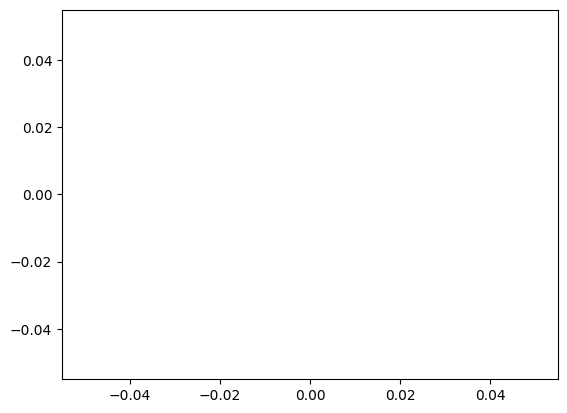

In [59]:
# Find and sort missing values
missing = train_data.isnull().sum()
missing = missing[missing > 0]
missing_percentage = (missing / len(train_data)) * 100

missing_percentage.sort_values(inplace=True)

# Plot
missing_percentage.plot.barh()
plt.xlabel('%')
plt.title('% of Missing values ')
plt.show()

print(missing_percentage.to_frame('% Missing values'))

### Handling Missing Values

In [61]:
from sklearn.impute import SimpleImputer
num_imputer = SimpleImputer(strategy='median')
train_data[num_columns] = num_imputer.fit_transform(train_data[num_columns])
test_data[num_columns] = num_imputer.transform(test_data[num_columns])

cat_imputer = SimpleImputer(strategy='most_frequent')
train_data[cat_columns] = cat_imputer.fit_transform(train_data[cat_columns])
test_data[cat_columns] = cat_imputer.transform(test_data[cat_columns])

In [63]:
# Confirm no missing values
train_data.isnull().sum().sum(), test_data.isnull().sum().sum()

(0, 0)

In [75]:
from sklearn.preprocessing import LabelEncoder, StandardScaler
# Encode categorical features
label_encoder = LabelEncoder()
combined_data = pd.concat([train_data, test_data], axis=0)

for column in combined_data.columns:
    combined_data[column] = label_encoder.fit_transform(combined_data[column])

# Split back into train and test
train_df_encoded = combined_data.iloc[:len(train_data)]
test_df_encoded = combined_data.iloc[len(train_data):]

# Split train data into features and target
X = train_df_encoded.drop('class', axis=1)
y = train_df_encoded['class']

# Prepare test data
test = test_df_encoded.drop('class', axis=1)

# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X)
X_test = scaler.transform(test)

In [77]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(random_state=42)

In [78]:
from time import time
from datetime import datetime
from sklearn.metrics import matthews_corrcoef, accuracy_score
from sklearn.model_selection import train_test_split, KFold
from sklearn.base import clone
import gc

kf = KFold(n_splits=5, shuffle=True, random_state=42)

def cross_val(X, y, kf, test):

    start= time()

    folds = kf 
    test_preds = np.zeros(len(test))
    oof_preds = np.zeros(len(y))
    y_vals = np.zeros(len(y))
    scores=[]

    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(X, y)):
    
        X_train_, y_train_ = X.iloc[train_idx], y.iloc[train_idx]
        X_val_, y_val_ = X.iloc[valid_idx], y.iloc[valid_idx]

        current_time = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
        print(f'Fitting Fold {n_fold + 1} started at {current_time}')

        model = clone(rf)
    
        model.fit(X_train_,y_train_, 
                 )
            
        y_pred_val = model.predict_proba(X_val_)[:,1]
        oof_preds[valid_idx] = y_pred_val
        y_vals[valid_idx] = y_val_
        score = matthews_corrcoef(y_val_, y_pred_val > 0.5)

        scores.append(score)  
        test_preds += model.predict_proba(test)[:,1]/ folds.get_n_splits()

        print(f'\nFold {n_fold + 1} MCC score : {score:.5f}')
        print('-' * 100)
        
        del X_train_, y_train_, X_val_, y_val_, model
        gc.collect()

    print(f'train MCC scores: {scores}')
    print(f'Mean MCC score +/- std. dev.: '
        f'{np.array(scores).mean():.5f} +/- {np.array(scores).std():.3f}')
    print(f'\nTime spent[s]: {(time()-start)/60:.2f} minutes')

    return oof_preds, y_vals, test_preds

In [79]:
train_preds, y_vals, test_preds = cross_val(X, y, kf, test)

Fitting Fold 1 started at 2024-08-15 02:15:19

Fold 1 MCC score : 0.98255
----------------------------------------------------------------------------------------------------
Fitting Fold 2 started at 2024-08-15 02:28:04


KeyboardInterrupt: 